<a href="https://colab.research.google.com/github/americanthinker/vector_search_applications_PUBLIC/blob/master/1_Data_Preprocessing_Week1_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Project 1.1

# Overview

Welcome to Week 1 of this course!  Over the course of two weeks we will build an application that utilizes both keyword and vector search as core components of a Retrieval Augmented Generation (RAG) system integrated with a Generative AI LLM. At a high level we will work with the following tech stack to build out each system component:

* [**SentenceTransformers**](https://www.sbert.net/): to convert text into vectors as well as rerank returned resuls
* [**OpenSearch**](https://www.opensearch.org): will act as both our keyword and vector database
* [**Llamaindex**](https://www.llamaindex.ai): will be our "glue" code which provides much of the heavy lifting
* OpenAI ChatGPT-3.5-Turbo: Our LLM of choice for answer synthesis and generation
* [**Streamlit**](https://streamlit.io/): We'll wrap up everything together for display to users through a Streamlit UI



<div>
<img src="https://www.python.org/static/community_logos/python-logo-master-v3-TM-flattened.png" style="text-align:center" width="300"/>
<img src="https://huggingface.co/spaces/sentence-transformers/README/resolve/main/sbertLogo.png" width="180"/>
<img src="https://d2908q01vomqb2.cloudfront.net/ca3512f4dfa95a03169c5a670a4c91a19b3077b4/2021/07/12/opensearch_logo_1000x500.png" width="200"/>
</div>
<div>
<img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
<img src="https://blogs.sap.com/wp-content/uploads/2023/08/1681142315open-ai-logo-1.png" width="250"/>
<img src="https://streamlit.io/images/brand/streamlit-logo-primary-colormark-darktext.svg" width="200"/>
</div>

# Problem
LLMs are an amazing technology but they do have their limitations.  How do we feed relevant information to a model that was trained on text from over two years ago?  
Below are the pain points that a RAG system addresses:

- LLMs are static, i.e. they are “frozen in time” and lack up-to-date information. It is not feasible to update their massive training datasets on a regular basis.
- They lack domain-specific knowledge - LLMs are trained for generalized tasks, meaning they do not know your company’s private data.
- They function as “black boxes” - it’s not easy to understand which sources an LLM was considering when they arrived at their conclusions.

Citation: Pinecone Blog -- ["Retrieval Augmented Generation (RAG): The Solution to GenAI Hallucinations"](https://www.pinecone.io/learn/retrieval-augmented-generation/)

# Approach
As a reminder we will divide the approach to building this system into four parts over two weeks-

#### Week One
* Part 1 (THIS NOTEBOOK):
  * Data ingest and preprocessing
  * Convert text into vectors
* Part 2:
  * Index data on OpenSearch database
  * Benchmark retrieval results  

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with ChatGPT-Turbo
* Part 4:
  * Benchmark overall system
  * Display results in Streamlit



Let's get cracking!

## Install libraries for this notebook

In [1]:
#visualization tool for displaying long load/processing times
!pip install tqdm --quiet
#data processing
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.8.41 --quiet
#logging output
!pip install loguru==0.7.0 --quiet
#easy way to access predefined envars
!pip install python-dotenv

## Download preprocessing file (helper code) from public repo

In [3]:
!curl -o preprocessing.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/preprocessing.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12776  100 12776    0     0  49378      0 --:--:-- --:--:-- --:--:-- 49519


## Download data from publicly accessible s3 bucket
Total download size should be about 25 MB

In [1]:
!curl -o impact_theory_data.json https://vector-search-applications-data.s3.us-west-2.amazonaws.com/impact_theory_updated_Nov1.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.4M  100 25.4M    0     0  13.6M      0  0:00:01  0:00:01 --:--:-- 13.6M


In [1]:
#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from torch import cuda
from tqdm.notebook import tqdm
from preprocessing import FileIO, Vectorizor, Splitters
from sentence_transformers import SentenceTransformer
from llama_index.text_splitter import SentenceSplitter
from concurrent.futures import ProcessPoolExecutor, as_completed

## Step 1 -->  Import YouTube/Podcast Transcripts

The hard part of this project i.e. collecting the data and wrangling it into an acceptable format has already been completed for you.  Yes, there is value in completing that step yourself, not the least of which is gaining a better understanding of the nuances and format of the data.  But, given our compressed time window, we will focus our efforts on the actual search application components of this project.

### The Data
The data - **385** podcast episodes to be exact - we will use for this project is a collection of transcribed podcast/youtube episodes of <a href="https://www.youtube.com/@TomBilyeu" target="_blank">The Impact Theory</a>.  From the About section of Impact Theory:
<h4 style='text-align: center;'><em>"Impact Theory™ is a weekly interview show that explores the mindsets of the world's highest achievers to learn their secrets to success.</em></h4>
<h4 style='text-align: center;'><em>Hosted by Quest Nutrition co-founder Tom Bilyeu, Impact Theory is designed to give people the tools and knowledge they need to unlock their potential and impact the world."</em></h4>

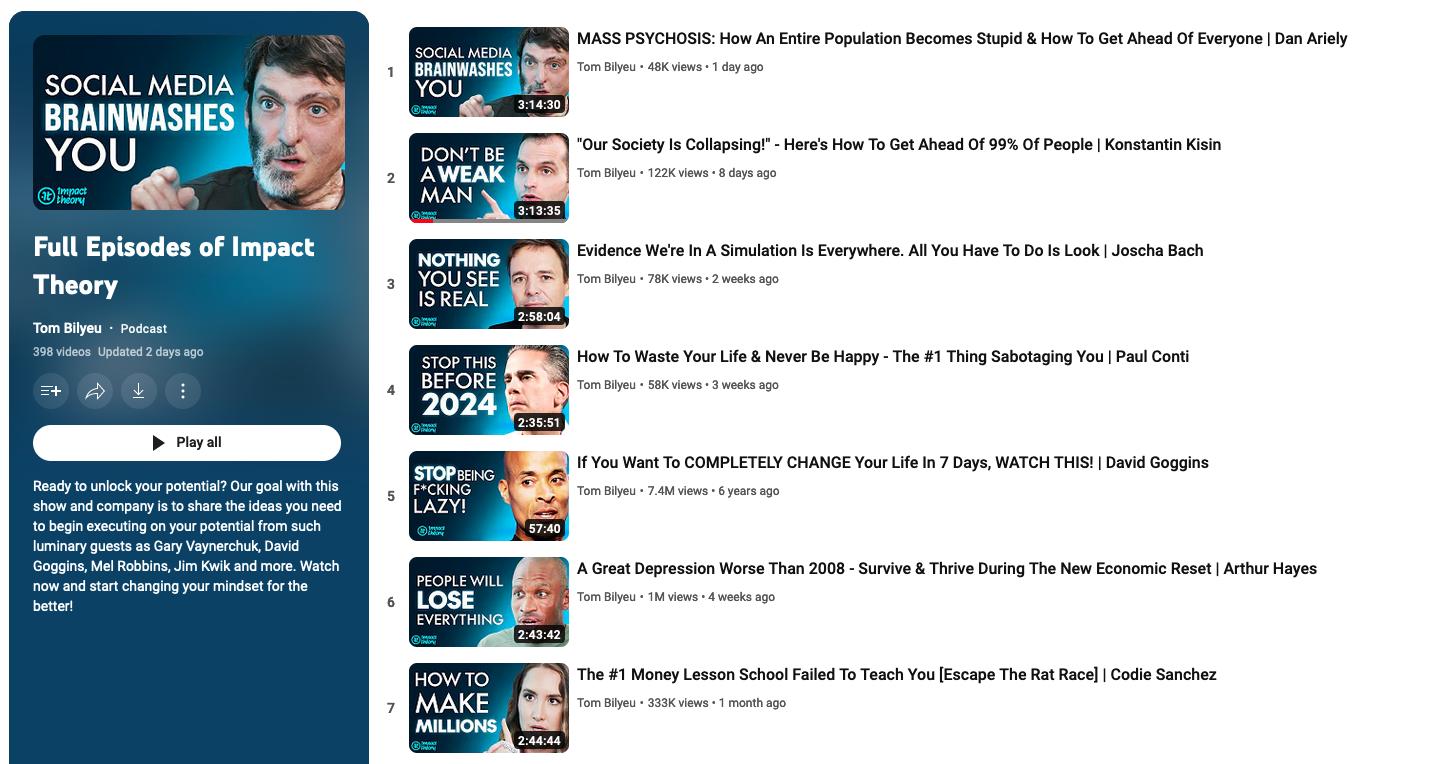

Throughout this course I will refer to the data as "YouTube" episodes or "podcast" episodes.  The reason for this is that the show is setup like a podcast and is released as a podcast, but it's also available on YouTube.  The episodes for this course were pulled from the podcast audio files and transcribed using the OpenAI open source Whisper model.  The transcriptions were then linked back to each episode using a unique **video_id**.  

### Import Data

Assuming you've already downloaded the data from the publicly available s3 bucket earlier, follow the instructions below to import the data and make it available in this notebook's namespace.  The below instructions assume you are running this notebook on Google Colab.  

  
**If you are not running this notebook on Colab, you'll need to readjust your data filepaths.**

In [2]:
#root folder on Google Colab is: /content/
root_folder = '/content/'
data_file = 'impact_theory_data.json'
data_path = os.path.join(root_folder, 'impact_theory_data.json')
data_path

'/content/impact_theory_data.json'

In [5]:
data_path = './data/impact_theory_data.json'

In [6]:
#should see 385 unique podcast entries
with open(data_path) as f:
    data =  json.load(f)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 385


### Data Review

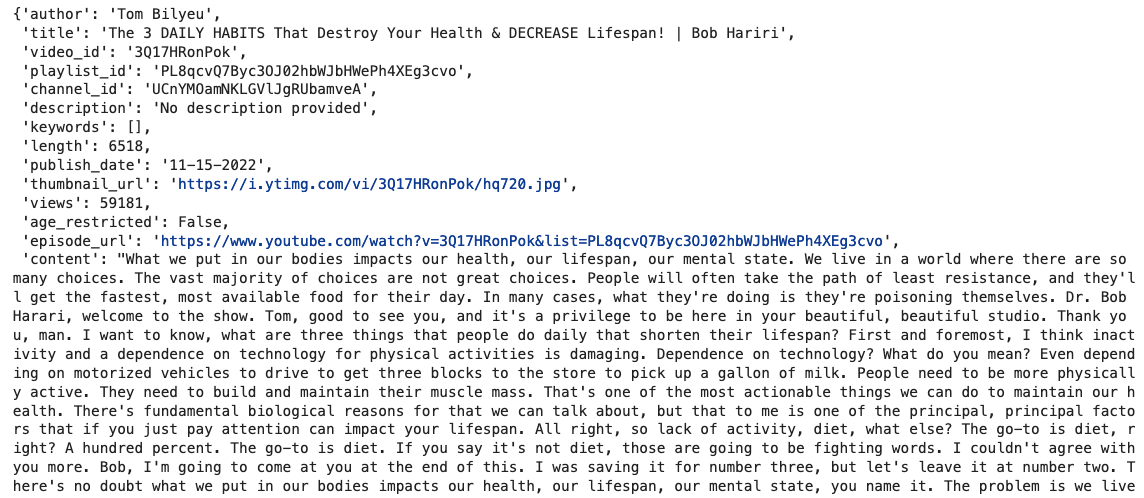

By taking a peek at the data we can see that each entry contains episode metadata (title, author, episode length, etc.) as well as the transcript of the episode located in the `content` field.  It may not jump out at you now, but we'll soon see that the `video_id` is one of the most important fields of the bunch, because it provides us with a unique identifier for each podcast episode.  Below is a down and dirty metadata glossary:

#### Metadata Glossary
- **author**: Episode author.
- **title**: Episode title.
- **video_id**: Unique identifier for each individual episode.
- **playlist_id**: Unique identifier for entire playlist of episodes.  All episodes in this dataset will have the same playlist_id.
- **channel_id**: REMOVE FROM DATA
- **description**: Summary of the episode.
- **keywords**: REMOVE FROM DATA
- **length**: Length of the episode in total seconds.
- **publish_date**: Date the episode was published to the YouTube channel.
- **thumbnail_url**: Hyperlink to the associated image of the YouTube episode.
- **views**: Number of views of this YouTube episode.
- **age_restricted**: REMOVE FROM DATA
- **episode_url**: Hyperlink to the episode on YouTube.
- **content**: The full transcript of the episode. 

The star of this show is the `content` field, as this is the field that we will be searching over when retrieving relevant documents.  The episode metadata, however, is also very useful.  Metadata can be used to boost searches, filter searches, improve answer synthesis, and several other creative use cases.  A good example of a metadata use case is using the `thumbnail_url` to associate an image with each search result in the User Interface as well as using the `episode_url` as a clickable link within the search result to take the end-user directly to the episode of interest. 

The `content` field of the example above is truncated for ease of viewing in the notebook. Let's get some statistics on the length of the content for each episode. We'll count (roughly) the number of words in each episode by splitting on whitespace.

#### Content Length Stats

In [5]:
lens = [len(d['content'].split()) for d in data]
df = pd.DataFrame(lens, columns=['Lengths'])
df.describe()

,Lengths
count,385.000000
mean,12884.654545
std,7741.439730
min,1819.000000
25%,7891.000000
50%,9899.000000
75%,16860.000000
max,48502.000000


In [6]:
mean_word_count = ceil(np.mean(lens))
token_to_word_ratio = 1.3
approx_token_count = ceil(mean_word_count * token_to_word_ratio)
print(f'The mean word count is about {mean_word_count} words, which corresponds to a rough token count of {approx_token_count}')

The mean word count is about 12885 words, which corresponds to a rough token count of 16751


#### Tokens

LLMs operate on tokens. Tokens are words or sub-parts of words, so the word "texting" might be broken into two tokens `text` and `##ing`. A [750 word document will be about 1000 tokens](https://www.anyscale.com/blog/num-every-llm-developer-should-know), in other words the token to word ratio is roughly 1.3 tokens = 1 word. (For a detailed discussion, see the section titled **Preprocessing and Chunking** in the Week 1 Course Content).

Given that the mean token count for each of our podcast episodes is over 16K tokens, we'll need a way to chunk our content so that we can effectively embed the transcript into several meaningful embeddings as opposed to one embedding for the entire transcript. 

## Step 2 -->  Sentence Splitting and Chunking (LlamaIndex)

### Chunking:
As addressed above, the open source embedding models that we will be working with have a `max_sequence_length` parameter far less than 16K tokens. In order to effectively process the content of our podcast episodes, we'll need to decide on a **Chunking Strategy**. There are several ways to split a document into chunks, but the one we'll cover for this course involves the following steps, as outlined in the associated diagram below:

1. Gather documents.  In our case we're considering a single Impact Theory episode to be a "document".
2. Decide how to split your documents.  When working with text documents, a good starting strategy is to split on sentence boundaries.  This decision at the very least, prevents input text from randomly being cut off in the middle of a paragraph.  We'll use an excellent piece of code written by Lllamindex namely, the `SentenceSplitter` class.
3. Pick a chunk size (refer to the detailed discussion in the course notes).  Given that the `all-miniLM-L6-v2` was trained on documents no greater than 256 tokens in length, we'll start with 256.  A chunk size of 256 strikes a good balance between information granularity and not blowing up the embedding space.
4. After splitting, a single episode will be broken up into `n` number of chunks, depending on the length of the episode.  Each of those chunks, however, should be no longer than 256 tokens.  Those chunks can then be passed through our embedding model as inputs and converted into vector representations.
5. The final step is combining the text chunks, their associated vectors, and the original metadata into a single dictionary (one for each chunk), in preparation for follow-on indexing on OpenSearch. 

![Chunking Strategy]( 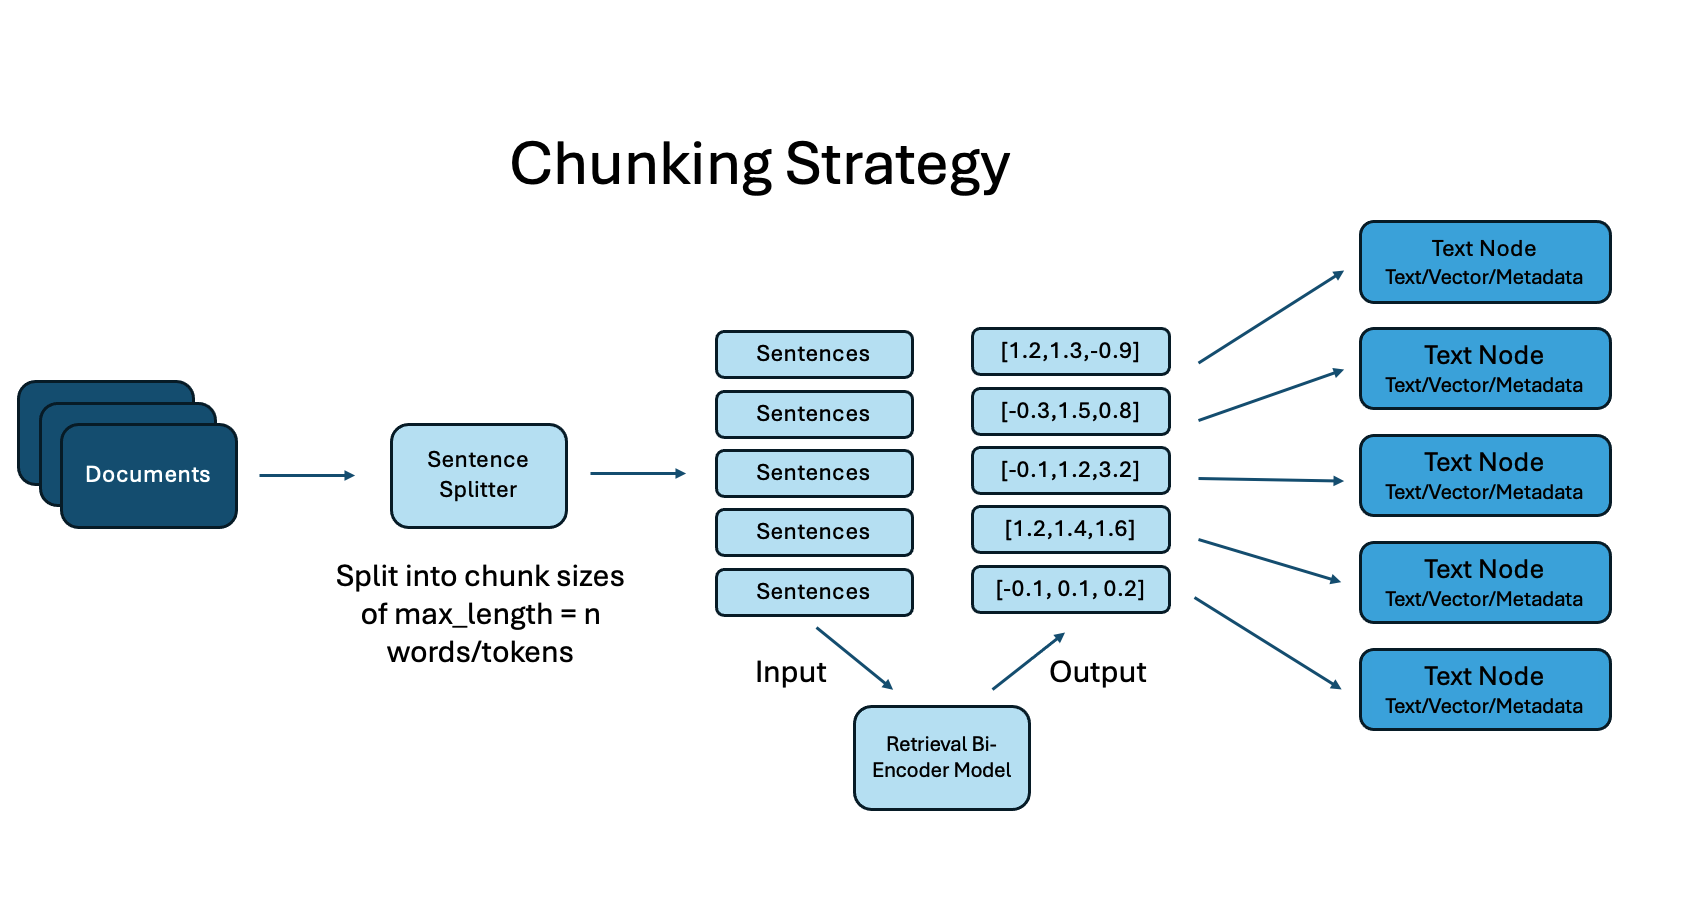)

#### Docstring for Llamaindex's SentenceSplitter Class

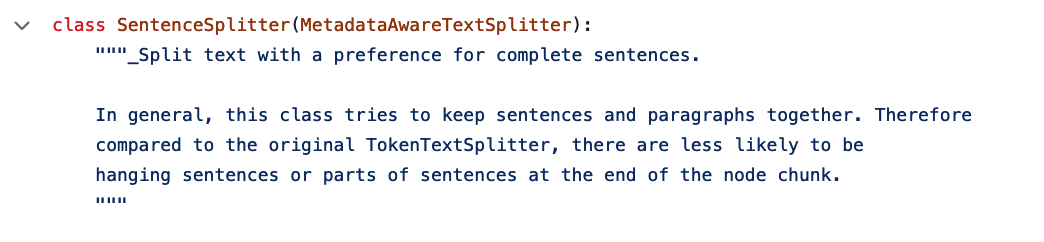

In [25]:
#set chunk size and instantiate a SentenceSplitter

chunk_size = 256
text_splitter = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=0)

# Assignment 1.1 - Chunking the Data

#### *Write a function that will split the original podcast episodes into chunks of chunk_size = n*
#### INSTRUCTIONS
    1. Iterate over the corpus of podcast episodes
    2. Extract the content_field value from each episode
    3. Split the "content" field using the text_splitter
    4. Return a list of lists of chunked texts
    5. #HINT: This function can be written in a single line of code

In [26]:
def split_contents(corpus: List[dict],
                   text_splitter: SentenceSplitter,
                   content_field: str='content'
                   ) -> List[List[str]]:
    '''
    Given a corpus of "documents" with text content, this function splits the
    content field into chunks sizes as specified by the text_splitter.

    Example
    -------
    corpus = [
            {'title': 'This is a cool show', 'content': 'There is so much good content on this show. \
              This would normally be a really long block of content. ... But for this example it will not be.'}, 
            {'title': 'Another Great Show', 'content': 'The content here is really good as well.  If you are \
              reading this you have too much time on your hands. ... More content, blah, blah.'}
           ]
           
    output = split_contents(data, text_splitter, content_field="content")
    
    output >>> [['There is so much good content on this show.', 'This would normally be a really long block of content.', \
                 'But for this example it will not be'], 
                ['The content here is really good as well.', 'If you are reading this you have too much time on your hands.', \
                 'More content, blah, blah.']
                ]
    '''
    
    ########################
    # START YOUR CODE HERE #
    ########################
    return [text_splitter.split_text(d[content_field]) for d in tqdm(corpus, "TEXT SPLITS")]

In [27]:
contents = split_contents(references, text_splitter)

TEXT SPLITS:   0%|          | 0/8918 [00:00<?, ?it/s]

In [11]:
def get_split_lengths(splits: List[List[str]]) -> pd.DataFrame:
    lengths = list(map(len, splits))
    return pd.DataFrame(lengths, columns=['# of Splits'])

min_split = np.argmin(get_split_lengths(contents))
min_split

9

In [33]:
# references = []

# for i, episode in enumerate(contents):
#     for j, chunk in enumerate(episode):
#         doc = {k:v for k,v in data[i].items() if k != 'content'}
#         doc['reference_id'] = f'{doc["video_id"]}_{j}'
#         doc['content'] = chunk
#         references.append(doc)

In [32]:
contents[5]    

["I think what solves correct is if you're happy and you're fulfilled in that relationship. That's it. Do you think that there is anything, um, preordained about what's going to make people happy and fulfilled? Yeah. I think appreciation for a man is one thing. I think men want to be appreciated. I really do. I think it's their job to go earn that appreciation. And I think women want to feel protected and loved and cared for fully. And they want to know that they have a position with that man where he is going to take care of them forever, or he is going to put all of his efforts into taking care and he gets fulfillment from it. I get a lot of fulfillment from taking care of my family. I love it. My little girls are spoiled for anything they want, you know, and I have heard you say you would not send for your daughters though. I won't. Now I'm glad you said that. So when they become 14, if they hear the wrong tweet or they want to start coming at me with the heat, I'll quickly remind t

## Step 3 -->  Encode Text Chunks as Vectors

#### SentenceTransformers

In [15]:
##############################################################################################################
######    Write short blurb here about Embedding Models in general and SentenceTransformers specifically #####
##############################################################################################################

In [13]:
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_path)

# Assignment 1.2 - Create Embeddings
#### *Write a function that will vectorize each content split list (single episode) and then merge the text content and their vector representations into a single list of (text, vector) tuples*
#### INSTRUCTIONS
1. Iterate over the content_splits **#HINT**: use `tqdm` here to track progress
2. For each list of content splits, call the model's `encode` method on the entire split/batch.  **#HINT**:Be sure to set the model's `device`.
3. Merge the text splits and resultant vectors into a single list of (text, vector) tuples.  **#HINT**: `zip` is your friend here. 
4. Append each list of tuples to the `text_vector_tuples` list container and return when complete.

In [56]:
def encode_content_splits(content_splits: List[List[str]],
                          model: SentenceTransformer,
                          device: str='cuda:0'
                          ) -> List[List[Tuple[str, np.array]]]:
    '''
    Encode content splits as vector embeddings from a list of content splits
    where each list of splits is a single podcast episode. 

    Example
    -------
    content_splits =  [['There is so much good content on this show.', 'This would normally be a really long block of content.'], 
                       ['The content here is really good as well.', 'More content, blah, blah.']
                      ]

    output = encode_content_splits(content_splits, model)
    
    output >>> [
                [('There is so much good content on this show.', array[ 1.78036056e-02, -1.93265956e-02,  3.61164124e-03, -5.89650944e-02,
                                                                         1.91510320e-02,  1.60808843e-02,  1.13610983e-01,  3.59948091e-02,
                                                                        -1.73066761e-02, -3.30348089e-02, -1.00898169e-01,  2.34847311e-02 
                                                                        ]
                                                                        )],
                 [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
                 [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
                 [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....]
    '''
    
    text_vector_tuples = [list(zip(chunk, model.encode(chunk, show_progress_bar=False, device='cuda:0'))) for chunk in tqdm(content_splits, 'EMBEDDINGS')]
    
    return text_vector_tuples    

In [15]:
tvt = encode_content_splits(contents, model)

  0%|          | 0/385 [00:00<?, ?it/s]

# Assignment 1.3 - Combining Metadata with Text/Vectors

#### *Write a function that will combine episode metadata from the original corpus with their associated text/vector tuples*
#### INSTRUCTIONS
1. `enumerate` over the `text_vector_list`.  We'll use the count (`i`) from this iteration to index against the corpus/data. 
   Reminder, in this step we are iterating over a list of lists, where each inner list is a single podcast episode 
   of text/vector tuples.  **#HINT**: use tqdm here to track progress
2. `enumerate` over each inner list (episode).  We'll use the count (`j`) from this iteration as a suffix when creating a new `doc_id` field (see step 4). 
3. Create a new dictionary filled with all items from `corpus[i]` except for the `content` field.  **#HINT**: use a dict comprehension here.
4. Update the new dict with a `doc_id` field by extracting the `video_id` value and combining it with the count (`j`) as a single string.
   **#HINT**: `doc_id = f'{video_id}_{j}'`
5. Update the new dict with a `content` field using the text from the enumerated tuple
6. Update the new dict with a `content_embedding` field using the vector from the enumerated tuple. Coerce the vector type from a np.array 
   to a list. 
7. Append each new dict to the `joined_documents` list container and return when complete. 
   **#HINT**: It looks like a lot, but this function should run under 2 seconds with 385 episodes.

#### Example of Sample output entry
*** Content embedding field has been truncated

![Sample Output]( 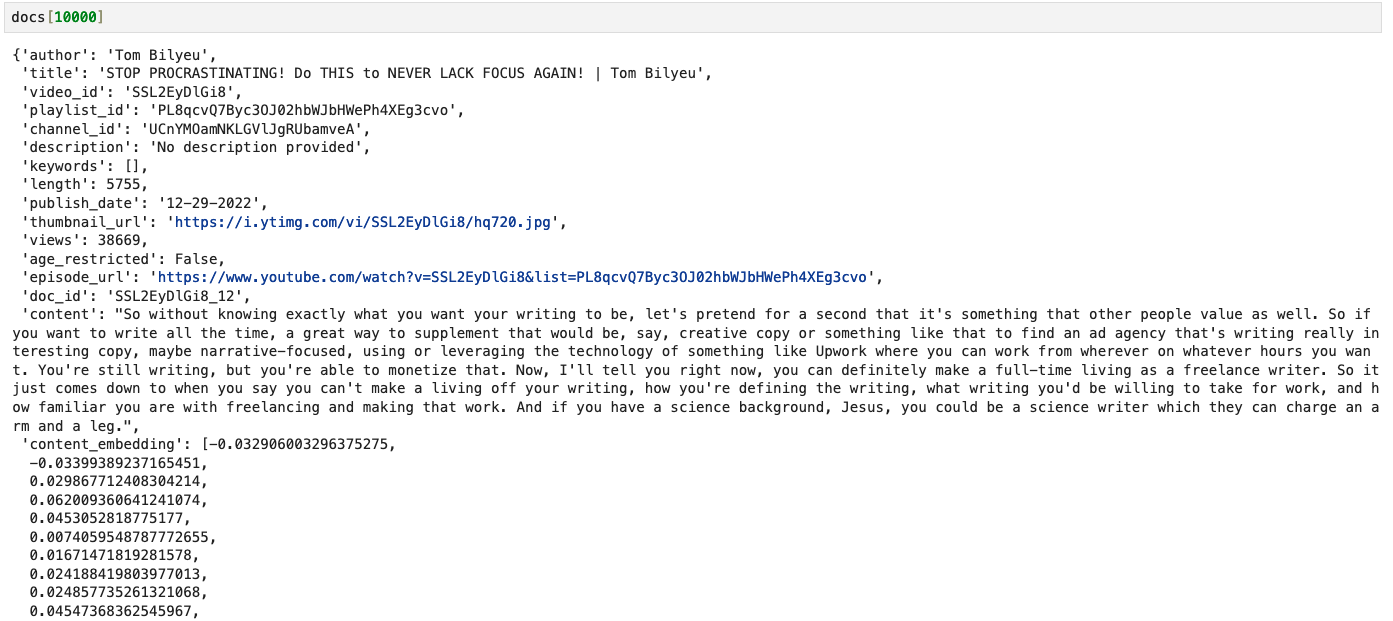)

In [57]:
def join_metadata(corpus: List[dict], 
                  text_vector_list: List[List[Tuple[str, np.array]]]
                 ) -> List[dict]:
    '''
    Combine episode metadata from original corpus with text/vectors tuples.
    Creates a new dictionary for each text/vector combination.
    '''

    joined_documents = []
    
    for i, episode in enumerate(tqdm(corpus, 'METADATA')):
        for j, chunk in enumerate(text_vector_list[i]):
            doc = {k:v for k,v in episode.items() if k != 'content'}
            video_id = doc['video_id']
            doc_id = f'{video_id}_{j}'
            doc['content'] = chunk[0]
            doc['content_embedding'] = chunk[1]
            joined_documents.append(doc)
    
    return joined_documents

In [35]:
docs = join_metadata(data, tvt)

  0%|          | 0/385 [00:00<?, ?it/s]

In [36]:
sum(list(map(len, tvt))), len(docs)

(27589, 27589)

## Step 4 --> Save Your Hard Work!

We've reached the final step in our data preparation phase.  If you've made it this far, you should have 27,589 distinct documents (assuming a `chunk_size` of 256), and are now ready to index those documents on your **OpenSearch host/database**. Before moving on to the indexing step, we'll want to store our dataset on disk, and then complete one more task that will prove useful during week 2.

The FileIO Class is a convenient wrapper that makes it easy to save data to disk in either json or [parquet format](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705).  The choice is yours on which format to use, however, a note of caution: the json format will take up 3-4x more room on disk than parquet. In the example screenshot below, you can see that the json clocks in at 390Mb while the parquet is only 77Mb. If we were using a multi-GB dataset then I would definitely recommend parquet, but given the dataset sizes we'll be working with in this course, it won't make a huge difference. 

![json_example]( 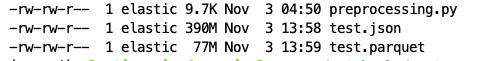)

Final note before saving: it's always a good idea to decide on a naming convention when saving out datasets, especially when the plan is to create multiple versions.  With that said, I suggest the following guidelines:
1. Name the dataset so it's easy to identify i.e. the name of the show: `impact-theory`
2. Hyphenate the name with the model used for text embeddings: `minilmL6`
3. Hyphenate the `chunk_size` you used for text chunking: `256`
4. If you really want to get specific you can also add a datetime suffix to the end, but that's up to you.

#### Example Naming Convention
`impact-theory-minilmL6-256.parquet`

In [42]:
#instantiate FileIO Class
io = FileIO()

#Define your output path
outpath = './delme-data.parquet'

#save to disk
io.save_as_parquet(file_path=outpath, data=docs, overwrite=True)

2023-11-03 18:52:17.623 | INFO     | preprocessing:save_as_parquet:38 - DataFrame saved as parquet file here: ./delme-data.parquet


In [44]:
#Verify that you can reload data

# data_with_vectors = io.load_parquet(file_path=outpath)
# data_with_vectors[0]

# Assignment 1.4 - Create Datasets with Multiple Chunk Sizes

#### *Write a function that will loop through a list of chunk sizes and create a new dataset for each chunk size.*
#### INSTRUCTIONS

1. Fill in the rest of the code wherever you see **None**.  Use the functions you wrote in the previous assignments.
   **Caveat: The type hint for the returned output is None, so no need to change it.**


In [58]:
def create_datasets(chunk_sizes: List[int],
                    corpus: List[dict],
                    model: SentenceTransformer,
                    file_outpath_prefix: str='./impact-theory-minilmL6',
                    content_field: str='content',
                    device: str='cuda:0' if cuda.is_available() else 'cpu'
                    ) -> None:
    '''
    Given a raw corpus of data, this function loops through the sizes in chunk_sizes
    and creates a new dataset where each dataset doc contains episode metadata and it's 
    associated text chunk and vector representation. Output is directly saved to disk. 
    '''
    io = FileIO()
    for size in chunk_sizes:
        print(f'Creating dataset using chunk_size: {size}')
        start = time.perf_counter()
        ########################
        # START YOUR CODE HERE #
        ########################
        text_splitter = SentenceSplitter(chunk_size=size, chunk_overlap=20)
        content_splits = split_contents(corpus, text_splitter)
        text_vector_tuples = encode_content_splits(content_splits, model, device)
        joined_docs = join_metadata(corpus, text_vector_tuples)
        file_path = f'{file_outpath_prefix}-{size}.parquet'
        io.save_as_parquet(file_path=file_path, data=joined_docs, overwrite=False)
        end = time.perf_counter() - start
        print(f'Total Time to process dataset of chunk_size ({size}): {round(end/60, 2)} minutes')

In [59]:
chunk_sizes = [64, 128, 192]
file_outpath_prefix = 'delme-data'

#Run this function when you're ready
create_datasets(chunk_sizes, data, model, file_outpath_prefix)

Creating dataset using chunk_size: 64


TEXT SPLITS:   0%|          | 0/385 [00:00<?, ?it/s]

EMBEDDINGS:   0%|          | 0/385 [00:00<?, ?it/s]

METADATA:   0%|          | 0/385 [00:00<?, ?it/s]

FileExistsError: File by name delme-data-64.parquet already exists, try using another file name or set overwrite to True.

Bad pipe message: %s [b')\x8c\xe6\x8e\x18\xac\x86\x93\x9b(', b'\xac\x89\xd6\xf8#\xd9 !z8\x1d1\x03\xb7:\xcd\x92\xabw\xe4\x87f\x94\xd9\xae\x96\xf4\xe3D\x1a\x18\x138\xe7\x0f\x17%p\x9d\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16']
Bad pipe message: %s [b'\x1f\x86\xa7w\xa87Y\xd1\x9e\xa6\x8a']
Bad pipe message: %s [b"\xa16\x14i\xad\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02"]
Ba

# Conclusion
That's a wrap folks.  At the end of this notebook you should have stored four separate datasets to disk with respective chunk sizes of 64, 128, 192, and 256.  In this next notebook we'll read that data into memory and index it on an AWS OpenSearch database.  See you there!

## OPTIONAL: OpenAI Ada Embeddings

In [ ]:
#loads envars from predefined env file
from dotenv import load_dotenv
load_dotenv('./env_file', override=True)
import openai

In [ ]:
!curl -o tiktoken_fx.py https://raw.githubusercontent.com/americanthinker/vector_search_applications_PUBLIC/master/tiktoken_functions.py

In [23]:
from openai.embeddings_utils import get_embedding, cosine_similarity
from tiktoken_fx import Tokenizer
from math import ceil
import time

openai.api_key = os.environ['OPENAI_API_KEY']
model_type = "text-embedding-ada-002"
tokenizer_type="cl100k_base"

#https://openai.com/pricing
price_per_1000 = 0.0001

tokenizer = Tokenizer(price=price_per_1000, model_type=tokenizer_type)
total_tokens, cost = tokenizer.get_cost(splits)

Total Tokens: 6,295,583	Cost: $0.63


In [24]:
#https://platform.openai.com/account/rate-limits
tokens_per_minute = 1000000
total_batches = ceil(total_tokens/tokens_per_minute)
batch_size = ceil(len(splits)/total_batches)
batch_size

5287

#### Working around OpenAI rate limits

In [25]:
#split text_chunks into roughly 1 million tokens total per group
def check_batch_size_cost(text_chunks: List[str],
                          batch_size: int,
                          tokenizer: Tokenizer,
                          tokens_per_minute: int=1000000):
  total_cost = 0
  for num in range(0,len(text_chunks),batch_size):
      chunks = text_chunks[num:num+batch_size]
      total_tokens, cost = tokenizer.get_cost(chunks)
      total_cost += cost
      if total_tokens > tokens_per_minute:
        print('Batch size exceeds OpenAI rate limit')
  return total_cost

In [26]:
check_batch_size_cost(splits, batch_size, tokenizer)

Total Tokens: 903,299	Cost: $0.09
Total Tokens: 901,305	Cost: $0.09
Total Tokens: 905,671	Cost: $0.09
Total Tokens: 896,700	Cost: $0.09
Total Tokens: 903,199	Cost: $0.09
Total Tokens: 897,850	Cost: $0.09
Total Tokens: 887,559	Cost: $0.09


0.6295583

In [27]:
def get_openai_embeddings(model_type: str,
                          text_chunks: List[str],
                          batch_size: int,
                          requests_per_min: int=3000):
  if batch_size > requests_per_min:
    batch_size = requests_per_min
  embeddings = []
  num_minutes = ceil(len(text_chunks)/batch_size)
  print(f'This process will take at least {num_minutes} minutes due to OpenAI rate limits.')
  for num in range(0, len(text_chunks), batch_size):
    batch = text_chunks[num:num+batch_size]
    response = openai.Embedding.create(model=model_type, input=batch)
    batch_embeddings = [e['embedding'] for e in response['data']]
    embeddings.extend(batch_embeddings)
    print("Pausing for a minute between batches...")
    time.sleep(60)
  return embeddings

In [68]:
embs = get_openai_embeddings(model_type, splits[:100], batch_size)

This process will take at least 1 minutes due to OpenAI rate limits.
Pausing for a minute between batches...


<div>
    <img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
</div>

In [28]:
from llama_index import ServiceContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings import OpenAIEmbedding

In [29]:
embed_model = OpenAIEmbedding(embed_batch_size=150)
service_context = ServiceContext.from_defaults(embed_model=embed_model)

In [97]:
%%time
llama_embs = embed_model.get_text_embedding_batch(splits, show_progress=True)

Generating embeddings:   0%|          | 0/37007 [00:00<?, ?it/s]

CPU times: user 11.9 s, sys: 1.53 s, total: 13.5 s
Wall time: 6min 44s


In [30]:
embed_model.embed_batch_size

150

In [104]:
llama_df = pd.DataFrame({'text': splits, 'embeddings': llama_embs})

In [105]:
llama_df

,text,embeddings
0,"I'm not an advocate for porn, but the one thin...","[-0.03930378332734108, -0.001958907349035144, ..."
1,I think there's a lot of things involved. I th...,"[-0.01497386023402214, -0.0033485570456832647,..."
2,I think that's a really big problem for men. W...,"[0.003110474906861782, -0.015326040796935558, ..."
3,A lot of guys are not meeting that expectation...,"[-0.016313627362251282, -0.019802747294306755,..."
4,"That's no longer being celebrated. Instead, it...","[-0.024560874328017235, -0.01674359105527401, ..."
...,...,...
37002,"And that's really my main focus, is to, you kn...","[-0.0013658697716891766, -0.000394923350540921..."
37003,It's this ongoing pursuit. And the real way th...,"[-0.019580287858843803, -0.00517278304323554, ..."
37004,It's hilarious. You have to hear it. It's an a...,"[-0.017547881230711937, -0.031159311532974243,..."
37005,I really appreciate it. Thank you. Thank you. ...,"[-0.012008767575025558, -0.028076112270355225,..."


In [107]:
df.to_parquet('./impact_theory_llama_embs.parquet', index=False)

In [108]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37007 entries, 0 to 37006
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   texts       37007 non-null  object
 1   embeddings  37007 non-null  object
dtypes: object(2)
memory usage: 464.0 MB


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37007 entries, 0 to 37006
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   texts       37007 non-null  object
 1   embeddings  37007 non-null  object
dtypes: object(2)
memory usage: 578.4+ KB
